# LSTM - vanilla

In [17]:
best_model = "best_model14.pt"

## Load and prepare data

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [5]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


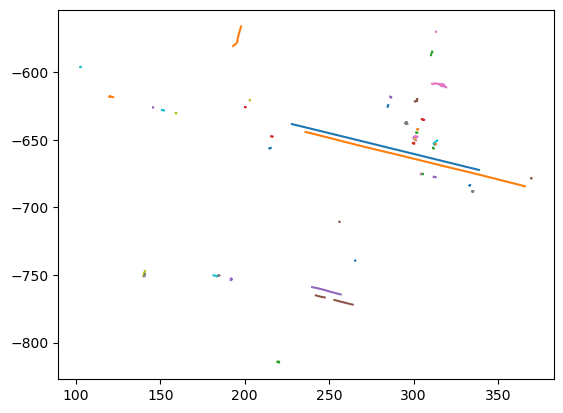

In [6]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [10]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Encoder: takes in past trajectory
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder: predicts future positions one step at a time
        self.decoder = nn.LSTM(input_size=2, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, forcing_ratio = 0.5):
    # def forward(self, data):
        x = data.x[..., :5]  # Use position + velocity
        x = x.reshape(-1, 50, 50, 5)[:, 0, :, :]  # (batch, 50, 5), ego only
        
        batch_size = x.size(0)
        
        if self.training:
            future = data.y.view(batch_size, 60, 2) # (batch, 60, 2)

        device = x.device

        # Encode past
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input with last observed position
        decoder_input = x[:, -1, :2].unsqueeze(1)  # (batch, 1, 2)
        
        # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            # TODO: remove forcing ratio?
            if self.training and random.random() < forcing_ratio:
            # if self.training:
                decoder_input = future[:, t].unsqueeze(1)  # ground truth
                # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
            else:
                decoder_input = pred.detach()  # predicted output as next input
                # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

In [22]:
# # Example of basic model with simple attention mechanism
# class SimpleLSTMWithAttn(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
#         super(SimpleLSTMWithAttn, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
#         # Simple attention mechanism
#         self.attention = nn.Linear(hidden_dim, 1)
        
#         # Add multi-layer prediction head for better results
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights properly
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.0)
        
#     def forward(self, data):
#         x = data.x[..., :5]
#         x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
#         x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
#         # Process through LSTM
#         lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        
#         # Apply attention mechanism
#         attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
#         attended_features = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, hidden_dim)
        
#         # Process through prediction head
#         features = self.relu(self.fc1(attended_features))
#         features = self.dropout(features)
#         out = self.fc2(features)
        
#         # Reshape to (batch_size, 60, 2)
#         return out.view(-1, 60, 2)

# Train

In [18]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch, forcing_ratio=forcing_ratio)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                # batch.scale turns scale from 7.0 or (1,) shape i.e. scalar to (B,) shape
                # batch.origin turns origin from (1,2) shape to (B,2)
                
                # then .view(-1, 1, 1) turns scale from (B,) to (B, 1, 1)
                # then .unsqueeze(1) turns origin from (B, 2) to (B, 1, 2)
                # because pred and y have shapes (B, 60, 2) so these transformations make them compatible for the calculation
                
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [19]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM(input_dim=5, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [20]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_73396/2425023728.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_73396/2425023728.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:19<32:20, 19.60s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 0.6946 | Val MSE 7.6300 | Val MAE 13.3659 | Val MSE 373.8692
Sample pred first 3 steps: [[-0.04502406 -0.01359732]
 [-0.05280701 -0.01703607]
 [-0.07282741 -0.0424345 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 7.629984


Epoch:   2%|▏         | 2/100 [00:39<31:58, 19.57s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.0028 | Val MSE 5.9698 | Val MAE 10.1509 | Val MSE 292.5221
Validation improved: 7.629984 -> 5.969840


Epoch:   3%|▎         | 3/100 [00:58<31:38, 19.57s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.0007 | Val MSE 6.2347 | Val MAE 11.1051 | Val MSE 305.4987


Epoch:   4%|▍         | 4/100 [01:18<31:18, 19.57s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.0035 | Val MSE 11.4727 | Val MAE 15.0821 | Val MSE 562.1640


Epoch:   5%|▌         | 5/100 [01:37<30:54, 19.53s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.0005 | Val MSE 1.8349 | Val MAE 5.8826 | Val MSE 89.9098
Validation improved: 5.969840 -> 1.834895


Epoch:   6%|▌         | 6/100 [01:57<30:37, 19.54s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.0002 | Val MSE 23.5929 | Val MAE 20.0733 | Val MSE 1156.0527
Sample pred first 3 steps: [[-0.00891543  0.01307477]
 [-0.00369835  0.00968042]
 [-0.00426701 -0.00613374]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:   7%|▋         | 7/100 [02:16<30:21, 19.59s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.0025 | Val MSE 3.0984 | Val MAE 7.0086 | Val MSE 151.8196


Epoch:   8%|▊         | 8/100 [02:36<30:06, 19.64s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.0023 | Val MSE 16.9046 | Val MAE 20.0595 | Val MSE 828.3256


Epoch:   9%|▉         | 9/100 [02:56<29:46, 19.64s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.0009 | Val MSE 3.1560 | Val MAE 7.4618 | Val MSE 154.6428


Epoch:  10%|█         | 10/100 [03:15<29:25, 19.62s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.0026 | Val MSE 7.2607 | Val MAE 10.8712 | Val MSE 355.7733


Epoch:  11%|█         | 11/100 [03:35<29:05, 19.62s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.0004 | Val MSE 3.4572 | Val MAE 6.2618 | Val MSE 169.4031
Sample pred first 3 steps: [[-7.2017312e-05  5.0129741e-04]
 [ 2.9153936e-03 -9.5365942e-04]
 [ 3.5055839e-03 -4.0395707e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  12%|█▏        | 12/100 [03:55<28:46, 19.62s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.0001 | Val MSE 1.5210 | Val MAE 5.1580 | Val MSE 74.5266
Validation improved: 1.834895 -> 1.520951


Epoch:  13%|█▎        | 13/100 [04:14<28:24, 19.59s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.0003 | Val MSE 21.3127 | Val MAE 19.0428 | Val MSE 1044.3233


Epoch:  14%|█▍        | 14/100 [04:34<28:04, 19.58s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.0026 | Val MSE 8.1365 | Val MAE 9.2712 | Val MSE 398.6872


Epoch:  15%|█▌        | 15/100 [04:53<27:45, 19.59s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.0007 | Val MSE 2.5195 | Val MAE 6.6722 | Val MSE 123.4576


Epoch:  16%|█▌        | 16/100 [05:13<27:26, 19.61s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.0003 | Val MSE 6.1778 | Val MAE 11.3904 | Val MSE 302.7141
Sample pred first 3 steps: [[-0.01018067  0.00272926]
 [-0.02280096  0.01004304]
 [-0.05458922  0.02571731]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [05:33<27:04, 19.57s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.0014 | Val MSE 10.6482 | Val MAE 16.1656 | Val MSE 521.7630


Epoch:  18%|█▊        | 18/100 [05:52<26:43, 19.55s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.0016 | Val MSE 38.8954 | Val MAE 30.9425 | Val MSE 1905.8741


Epoch:  19%|█▉        | 19/100 [06:12<26:23, 19.54s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.0033 | Val MSE 1.8121 | Val MAE 5.7142 | Val MSE 88.7925


Epoch:  20%|██        | 20/100 [06:31<26:05, 19.56s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.0002 | Val MSE 1.1862 | Val MAE 4.7268 | Val MSE 58.1228
Validation improved: 1.520951 -> 1.186180


Epoch:  21%|██        | 21/100 [06:51<25:46, 19.58s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.0008 | Val MSE 1.1296 | Val MAE 4.2547 | Val MSE 55.3526
Sample pred first 3 steps: [[-0.0006554  -0.00292525]
 [-0.0050273  -0.01056344]
 [-0.00078927 -0.01652931]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 1.186180 -> 1.129644


Epoch:  22%|██▏       | 22/100 [07:10<25:28, 19.59s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.0004 | Val MSE 1.5785 | Val MAE 5.0541 | Val MSE 77.3476


Epoch:  23%|██▎       | 23/100 [07:30<25:05, 19.55s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.0018 | Val MSE 3.0683 | Val MAE 8.1840 | Val MSE 150.3474


Epoch:  24%|██▍       | 24/100 [07:49<24:44, 19.54s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.0004 | Val MSE 2.0752 | Val MAE 6.1489 | Val MSE 101.6840


Epoch:  25%|██▌       | 25/100 [08:09<24:23, 19.52s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.0013 | Val MSE 2.9329 | Val MAE 7.3477 | Val MSE 143.7099


Epoch:  26%|██▌       | 26/100 [08:28<24:04, 19.52s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.0014 | Val MSE 2.9348 | Val MAE 6.5427 | Val MSE 143.8060
Sample pred first 3 steps: [[-0.00381515 -0.0069498 ]
 [-0.00972284 -0.01378775]
 [-0.01431381 -0.02448569]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  27%|██▋       | 27/100 [08:48<23:37, 19.41s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.0013 | Val MSE 2.3629 | Val MAE 7.4691 | Val MSE 115.7813


Epoch:  28%|██▊       | 28/100 [09:07<23:11, 19.33s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.0062 | Val MSE 1.3981 | Val MAE 4.8309 | Val MSE 68.5045


Epoch:  29%|██▉       | 29/100 [09:26<22:47, 19.26s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.0011 | Val MSE 1.4734 | Val MAE 5.1856 | Val MSE 72.1968


Epoch:  30%|███       | 30/100 [09:45<22:24, 19.20s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.0010 | Val MSE 0.9698 | Val MAE 4.1873 | Val MSE 47.5203
Validation improved: 1.129644 -> 0.969801


Epoch:  31%|███       | 31/100 [10:04<22:00, 19.14s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.0019 | Val MSE 4.4821 | Val MAE 8.7808 | Val MSE 219.6233
Sample pred first 3 steps: [[ 0.0018134  -0.0037807 ]
 [ 0.02844033 -0.0141212 ]
 [ 0.03880011 -0.02281468]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  32%|███▏      | 32/100 [10:23<21:41, 19.14s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.0010 | Val MSE 0.8062 | Val MAE 3.4230 | Val MSE 39.5050
Validation improved: 0.969801 -> 0.806224


Epoch:  33%|███▎      | 33/100 [10:42<21:23, 19.15s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.0028 | Val MSE 1.4242 | Val MAE 4.9122 | Val MSE 69.7882


Epoch:  34%|███▍      | 34/100 [11:01<21:04, 19.16s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.0014 | Val MSE 0.5685 | Val MAE 3.0476 | Val MSE 27.8572
Validation improved: 0.806224 -> 0.568515


Epoch:  35%|███▌      | 35/100 [11:20<20:45, 19.16s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.0083 | Val MSE 1.1950 | Val MAE 5.2194 | Val MSE 58.5554


Epoch:  36%|███▌      | 36/100 [11:40<20:24, 19.14s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.0043 | Val MSE 0.4839 | Val MAE 2.7606 | Val MSE 23.7118
Sample pred first 3 steps: [[ 0.00554566 -0.00553234]
 [ 0.02286753  0.00327224]
 [ 0.02353904 -0.00262797]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.568515 -> 0.483915


Epoch:  37%|███▋      | 37/100 [11:59<20:04, 19.11s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.0030 | Val MSE 0.7308 | Val MAE 3.4047 | Val MSE 35.8071


Epoch:  38%|███▊      | 38/100 [12:18<19:47, 19.15s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.0067 | Val MSE 3.8259 | Val MAE 9.1030 | Val MSE 187.4682


Epoch:  39%|███▉      | 39/100 [12:37<19:33, 19.23s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.0074 | Val MSE 0.6371 | Val MAE 3.3112 | Val MSE 31.2160


Epoch:  40%|████      | 40/100 [13:25<27:43, 27.73s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.0037 | Val MSE 0.5643 | Val MAE 3.0212 | Val MSE 27.6497


Epoch:  41%|████      | 41/100 [13:44<24:44, 25.17s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.0132 | Val MSE 0.5981 | Val MAE 2.9647 | Val MSE 29.3071
Sample pred first 3 steps: [[-0.01221197 -0.00720825]
 [-0.01102703 -0.01394634]
 [-0.00195505 -0.01716675]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [25:56<3:49:19, 237.23s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.0118 | Val MSE 0.6695 | Val MAE 3.3790 | Val MSE 32.8075


Epoch:  43%|████▎     | 43/100 [26:16<2:43:29, 172.10s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.0183 | Val MSE 0.5603 | Val MAE 2.9844 | Val MSE 27.4525


Epoch:  44%|████▍     | 44/100 [26:35<1:57:50, 126.26s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.0332 | Val MSE 0.7372 | Val MAE 3.5995 | Val MSE 36.1228


Epoch:  45%|████▌     | 45/100 [26:54<1:26:11, 94.03s/epoch] 

Epoch 044 | LR 0.000696 | Train MSE 0.0477 | Val MSE 0.4800 | Val MAE 2.6574 | Val MSE 23.5208
Validation improved: 0.483915 -> 0.480016


Epoch:  46%|████▌     | 46/100 [27:17<1:05:15, 72.50s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.0513 | Val MSE 0.8515 | Val MAE 4.1050 | Val MSE 41.7235
Sample pred first 3 steps: [[ 0.01134121 -0.0013166 ]
 [ 0.00509023  0.00659728]
 [-0.01547665  0.019642  ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [27:39<50:52, 57.60s/epoch]  

Epoch 046 | LR 0.000628 | Train MSE 0.0817 | Val MSE 1.1673 | Val MAE 4.7562 | Val MSE 57.1955


Epoch:  48%|████▊     | 48/100 [28:02<40:50, 47.12s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1092 | Val MSE 0.9218 | Val MAE 3.7493 | Val MSE 45.1692


Epoch:  49%|████▉     | 49/100 [28:25<33:47, 39.75s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 1.5320 | Val MSE 2.0564 | Val MAE 6.0240 | Val MSE 100.7633


Epoch:  50%|█████     | 50/100 [28:47<28:49, 34.59s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.6434 | Val MSE 0.8062 | Val MAE 3.6464 | Val MSE 39.5034


Epoch:  51%|█████     | 51/100 [29:10<25:16, 30.96s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.9065 | Val MSE 1.1801 | Val MAE 4.2552 | Val MSE 57.8247
Sample pred first 3 steps: [[-0.04192623  0.02327325]
 [-0.01558202  0.03660211]
 [ 0.02717655  0.03923628]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  52%|█████▏    | 52/100 [29:33<22:49, 28.53s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.8230 | Val MSE 0.6688 | Val MAE 3.2708 | Val MSE 32.7721


Epoch:  53%|█████▎    | 53/100 [29:55<20:50, 26.61s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.6112 | Val MSE 0.5058 | Val MAE 2.6738 | Val MSE 24.7858


Epoch:  54%|█████▍    | 54/100 [30:17<19:20, 25.23s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.5159 | Val MSE 0.5067 | Val MAE 2.7234 | Val MSE 24.8295


Epoch:  55%|█████▌    | 55/100 [30:39<18:16, 24.36s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.4635 | Val MSE 0.4431 | Val MAE 2.5773 | Val MSE 21.7116
Validation improved: 0.480016 -> 0.443094


Epoch:  56%|█████▌    | 56/100 [31:01<17:24, 23.73s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.4318 | Val MSE 0.4213 | Val MAE 2.3878 | Val MSE 20.6444
Sample pred first 3 steps: [[0.02399179 0.01329268]
 [0.01166372 0.03080136]
 [0.01065866 0.0226118 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.443094 -> 0.421315


Epoch:  57%|█████▋    | 57/100 [31:24<16:45, 23.40s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.4071 | Val MSE 0.3829 | Val MAE 2.2370 | Val MSE 18.7628
Validation improved: 0.421315 -> 0.382915


Epoch:  58%|█████▊    | 58/100 [31:46<16:09, 23.07s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.3829 | Val MSE 0.3599 | Val MAE 2.1288 | Val MSE 17.6359
Validation improved: 0.382915 -> 0.359917


Epoch:  59%|█████▉    | 59/100 [32:09<15:39, 22.91s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.3692 | Val MSE 0.3408 | Val MAE 2.1906 | Val MSE 16.6971
Validation improved: 0.359917 -> 0.340758


Epoch:  60%|██████    | 60/100 [32:31<15:11, 22.80s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.3557 | Val MSE 0.3370 | Val MAE 2.2428 | Val MSE 16.5120
Validation improved: 0.340758 -> 0.336980


Epoch:  61%|██████    | 61/100 [32:54<14:46, 22.73s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.3419 | Val MSE 0.3315 | Val MAE 2.1329 | Val MSE 16.2411
Sample pred first 3 steps: [[0.01998217 0.0161657 ]
 [0.02068871 0.01760675]
 [0.02588302 0.00878574]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.336980 -> 0.331451


Epoch:  62%|██████▏   | 62/100 [33:16<14:21, 22.68s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.3344 | Val MSE 0.3006 | Val MAE 1.8918 | Val MSE 14.7303
Validation improved: 0.331451 -> 0.300618


Epoch:  63%|██████▎   | 63/100 [33:39<14:00, 22.71s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.3206 | Val MSE 0.2920 | Val MAE 1.9205 | Val MSE 14.3086
Validation improved: 0.300618 -> 0.292013


Epoch:  64%|██████▍   | 64/100 [34:02<13:39, 22.76s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.3237 | Val MSE 0.3267 | Val MAE 2.0881 | Val MSE 16.0092


Epoch:  65%|██████▌   | 65/100 [34:25<13:17, 22.80s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.3124 | Val MSE 0.3018 | Val MAE 1.9776 | Val MSE 14.7876


Epoch:  66%|██████▌   | 66/100 [34:48<12:53, 22.74s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.3070 | Val MSE 0.2743 | Val MAE 1.7295 | Val MSE 13.4394
Sample pred first 3 steps: [[ 0.02490485  0.00530759]
 [-0.00742888  0.01629725]
 [-0.00891832  0.018665  ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.292013 -> 0.274275


Epoch:  67%|██████▋   | 67/100 [35:10<12:31, 22.78s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.3058 | Val MSE 0.3047 | Val MAE 2.0923 | Val MSE 14.9287


Epoch:  68%|██████▊   | 68/100 [35:33<12:11, 22.85s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.2995 | Val MSE 0.2905 | Val MAE 1.9381 | Val MSE 14.2335


Epoch:  69%|██████▉   | 69/100 [35:56<11:43, 22.69s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.2992 | Val MSE 0.3173 | Val MAE 2.0528 | Val MSE 15.5497


Epoch:  70%|███████   | 70/100 [36:18<11:18, 22.61s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.2964 | Val MSE 0.2754 | Val MAE 1.8177 | Val MSE 13.4922


Epoch:  71%|███████   | 71/100 [36:41<11:00, 22.77s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.2892 | Val MSE 0.2711 | Val MAE 1.8006 | Val MSE 13.2854
Sample pred first 3 steps: [[0.02423834 0.00414589]
 [0.00667322 0.00939411]
 [0.01357022 0.01396515]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.274275 -> 0.271132


Epoch:  72%|███████▏  | 72/100 [37:04<10:35, 22.69s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.2869 | Val MSE 0.2813 | Val MAE 1.8573 | Val MSE 13.7842


Epoch:  73%|███████▎  | 73/100 [37:27<10:18, 22.90s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.2879 | Val MSE 0.2643 | Val MAE 1.7238 | Val MSE 12.9516
Validation improved: 0.271132 -> 0.264319


Epoch:  74%|███████▍  | 74/100 [37:50<09:50, 22.73s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.2873 | Val MSE 0.2645 | Val MAE 1.7293 | Val MSE 12.9610


Epoch:  75%|███████▌  | 75/100 [38:12<09:25, 22.61s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.2815 | Val MSE 0.2679 | Val MAE 1.7414 | Val MSE 13.1280


Epoch:  76%|███████▌  | 76/100 [38:34<09:00, 22.53s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.2799 | Val MSE 0.2572 | Val MAE 1.6890 | Val MSE 12.6020
Sample pred first 3 steps: [[ 0.02341874 -0.00124   ]
 [ 0.00265679 -0.00360659]
 [ 0.00858107 -0.00272467]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.264319 -> 0.257185


Epoch:  77%|███████▋  | 77/100 [38:56<08:36, 22.45s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.2766 | Val MSE 0.2592 | Val MAE 1.7108 | Val MSE 12.6991


Epoch:  78%|███████▊  | 78/100 [39:19<08:13, 22.42s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.2768 | Val MSE 0.2579 | Val MAE 1.7560 | Val MSE 12.6373


Epoch:  79%|███████▉  | 79/100 [39:41<07:50, 22.38s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.2704 | Val MSE 0.2506 | Val MAE 1.6505 | Val MSE 12.2816
Validation improved: 0.257185 -> 0.250646


Epoch:  80%|████████  | 80/100 [40:03<07:27, 22.36s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.2736 | Val MSE 0.2715 | Val MAE 1.8872 | Val MSE 13.3022


Epoch:  81%|████████  | 81/100 [40:26<07:04, 22.35s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.2695 | Val MSE 0.2540 | Val MAE 1.6865 | Val MSE 12.4457
Sample pred first 3 steps: [[0.0233967  0.0053085 ]
 [0.00446602 0.0018596 ]
 [0.0113713  0.00757965]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  82%|████████▏ | 82/100 [40:48<06:41, 22.30s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.2695 | Val MSE 0.2668 | Val MAE 1.8574 | Val MSE 13.0708


Epoch:  83%|████████▎ | 83/100 [41:10<06:18, 22.28s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.2647 | Val MSE 0.2493 | Val MAE 1.6430 | Val MSE 12.2174
Validation improved: 0.250646 -> 0.249336


Epoch:  84%|████████▍ | 84/100 [41:33<05:56, 22.31s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.2661 | Val MSE 0.2541 | Val MAE 1.6839 | Val MSE 12.4496


Epoch:  85%|████████▌ | 85/100 [41:55<05:34, 22.29s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.2645 | Val MSE 0.2553 | Val MAE 1.6965 | Val MSE 12.5080


Epoch:  86%|████████▌ | 86/100 [42:17<05:11, 22.28s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.2593 | Val MSE 0.2473 | Val MAE 1.6802 | Val MSE 12.1168
Sample pred first 3 steps: [[ 0.01585218  0.01001518]
 [-0.00093783  0.00784181]
 [ 0.00595992  0.01379247]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.249336 -> 0.247281


Epoch:  87%|████████▋ | 87/100 [42:39<04:49, 22.28s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.2605 | Val MSE 0.2441 | Val MAE 1.6181 | Val MSE 11.9618
Validation improved: 0.247281 -> 0.244118


Epoch:  88%|████████▊ | 88/100 [43:02<04:27, 22.26s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.2590 | Val MSE 0.2459 | Val MAE 1.6628 | Val MSE 12.0491


Epoch:  89%|████████▉ | 89/100 [43:24<04:05, 22.29s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.2556 | Val MSE 0.2436 | Val MAE 1.6267 | Val MSE 11.9350
Validation improved: 0.244118 -> 0.243571


Epoch:  90%|█████████ | 90/100 [43:46<03:43, 22.34s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.2554 | Val MSE 0.2457 | Val MAE 1.6347 | Val MSE 12.0376


Epoch:  91%|█████████ | 91/100 [44:09<03:22, 22.47s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.2544 | Val MSE 0.2383 | Val MAE 1.6180 | Val MSE 11.6768
Sample pred first 3 steps: [[0.01843885 0.01434825]
 [0.00243834 0.01267222]
 [0.00789142 0.01271246]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.243571 -> 0.238302


Epoch:  92%|█████████▏| 92/100 [44:33<03:03, 22.93s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.2511 | Val MSE 0.2449 | Val MAE 1.6937 | Val MSE 11.9991


Epoch:  93%|█████████▎| 93/100 [44:56<02:40, 22.95s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.2528 | Val MSE 0.2421 | Val MAE 1.6643 | Val MSE 11.8624


Epoch:  94%|█████████▍| 94/100 [45:19<02:17, 22.83s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.2527 | Val MSE 0.2412 | Val MAE 1.6092 | Val MSE 11.8200


Epoch:  95%|█████████▌| 95/100 [45:38<01:49, 21.84s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.2498 | Val MSE 0.2390 | Val MAE 1.6452 | Val MSE 11.7105


Epoch:  96%|█████████▌| 96/100 [45:57<01:23, 20.88s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.2495 | Val MSE 0.2414 | Val MAE 1.6743 | Val MSE 11.8281
Sample pred first 3 steps: [[ 0.01868537  0.01193879]
 [-0.00018033  0.00686492]
 [ 0.00853542  0.01215694]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  97%|█████████▋| 97/100 [46:16<01:00, 20.25s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.2491 | Val MSE 0.2346 | Val MAE 1.5949 | Val MSE 11.4955
Validation improved: 0.238302 -> 0.234602


Epoch:  98%|█████████▊| 98/100 [46:34<00:39, 19.79s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.2475 | Val MSE 0.2352 | Val MAE 1.5925 | Val MSE 11.5241


Epoch:  99%|█████████▉| 99/100 [46:53<00:19, 19.51s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.2459 | Val MSE 0.2395 | Val MAE 1.6310 | Val MSE 11.7356


Epoch: 100%|██████████| 100/100 [47:12<00:00, 28.33s/epoch]


Epoch 099 | LR 0.000041 | Train MSE 0.2435 | Val MSE 0.2358 | Val MAE 1.6364 | Val MSE 11.5538
Val MSE: 11.4955


AutoRegressiveLSTM(
  (encoder): LSTM(5, 512, batch_first=True)
  (decoder): LSTM(2, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
)

# Final Pred

In [25]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto14.csv', index=True)